# XAI MODEL BUILD FOR DT

In [1]:
import pandas as pd
import joblib
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import seaborn as sns

from sklearn.model_selection import train_test_split

# Load Train and Test Datasets

In [2]:
df_train = pd.read_csv('../../../2_Modeling-Phase/train_and_test_datasets/NSL-KDD/train.csv')
df_test = pd.read_csv('../../../2_Modeling-Phase/train_and_test_datasets/NSL-KDD/test.csv')

In [3]:
X_train = df_train.drop(['binary_attack'], axis=1)  # Features
y_train = df_train['binary_attack']  # Target variable

In [4]:
X_test = df_test.drop(['binary_attack'], axis=1)  # Features
y_test = df_test['binary_attack']  # Target variable

# Load Model

In [5]:
# Load the trained model to a specific folder
model_folder = "../../../3_Post-Modeling-Phase/Trained_ML_models/Models-NSL-KDD/"
model_filename = "NSL-KDD_DecisionTree.joblib"
model_path = model_folder + model_filename

model = joblib.load(model_path)

# Feature Importance

In [6]:
feature_names = df_train.columns
feature_names = feature_names[:-1]

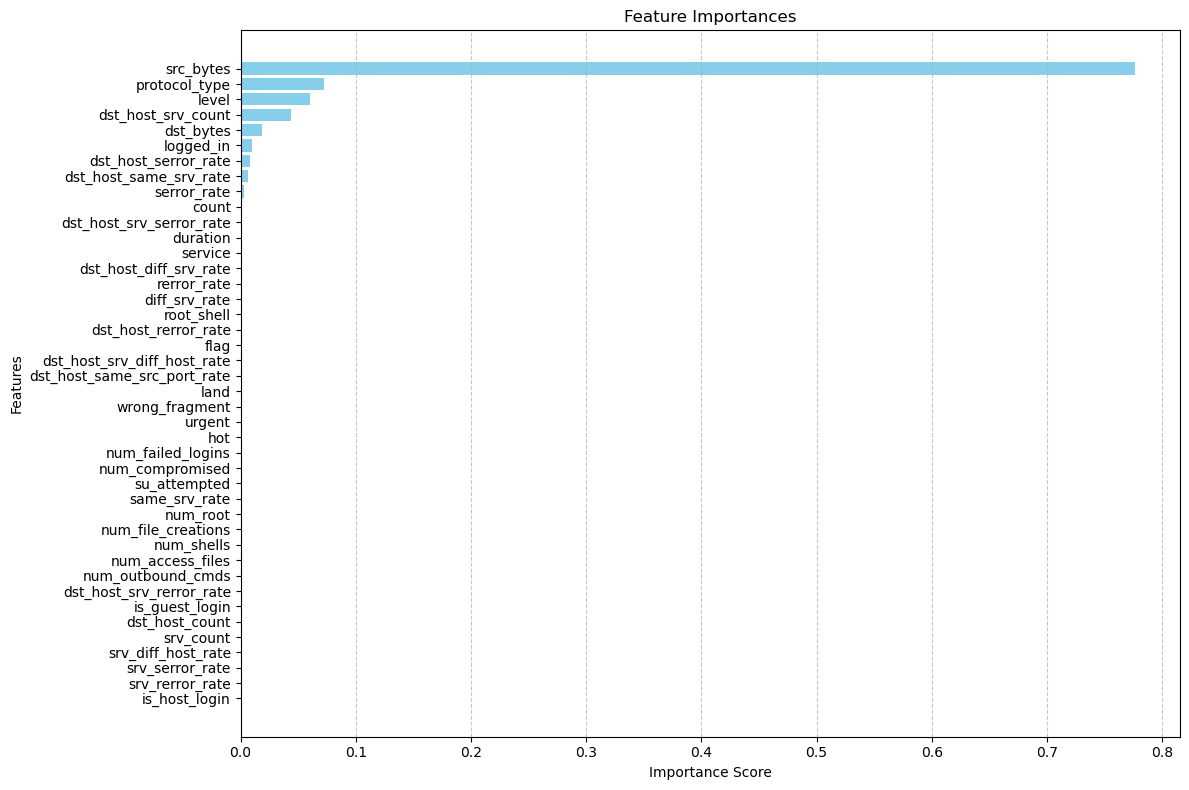

In [7]:
importances = model.feature_importances_


indices = np.argsort(importances)[::-1]


fig, ax = plt.subplots(figsize=(12, 8))

ax.barh(range(X_train.shape[1]), importances[indices], color="skyblue")

ax.set_yticks(range(X_train.shape[1]))
ax.set_yticklabels(feature_names[indices])

ax.set_title("Feature Importances")
ax.set_xlabel("Importance Score")
ax.set_ylabel("Features")

ax.invert_yaxis()

ax.grid(axis='x', linestyle='--', alpha=0.7)

plt.tight_layout()

plt.show()

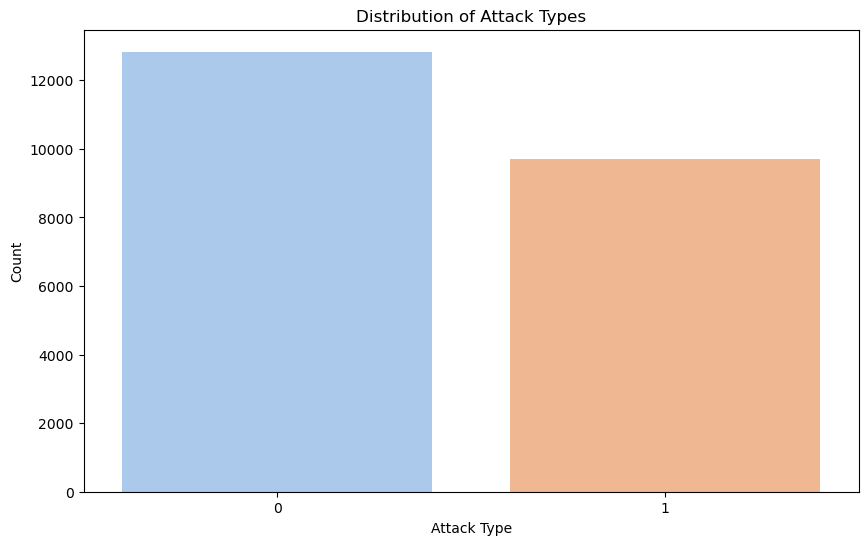

In [8]:
# Create the countplot
plt.figure(figsize=(10, 6))
sns.countplot(x=y_test, palette="pastel")

# Add labels and title
plt.xlabel("Attack Type")
plt.ylabel("Count")
plt.title("Distribution of Attack Types")

# Show the plot
plt.show()

# MODELS

In [9]:
def calculate_feature_importance(model, feature_names):
    """
    Calculate feature importance using Gini index.

    Returns:
    - DataFrame: DataFrame containing feature names and their corresponding Gini importance.
    """
    # Create DataFrame to hold feature names
    dfp_importance = pd.DataFrame({'feat_names': feature_names})
    dfp_importance['feature'] = dfp_importance.index.astype(str)  

    # Create DataFrame to hold Gini importance
    dfp_importance_gini = pd.DataFrame({'importance_gini': model.feature_importances_})
    dfp_importance_gini['feature'] = dfp_importance_gini.index.astype(str)  

    # Calculate percentile rank of Gini importance
    dfp_importance_gini['importance_gini_pct'] = dfp_importance_gini['importance_gini'].rank(pct=True)

    # Merge DataFrames and sort by importance
    dfp_importance = pd.merge(dfp_importance, dfp_importance_gini, on='feature', how='left')
    dfp_importance = dfp_importance.sort_values(by=['importance_gini', 'feature'], ascending=[False, True]).reset_index(drop=True)
    
    return dfp_importance

%time importance_table = calculate_feature_importance(model, feature_names)
importance_table

CPU times: user 7.03 ms, sys: 3.1 ms, total: 10.1 ms
Wall time: 18.4 ms


,feat_names,feature,importance_gini,importance_gini_pct
0,src_bytes,4,0.776748,1.000000
1,protocol_type,1,0.072094,0.976190
2,level,41,0.060345,0.952381
3,dst_host_srv_count,32,0.043998,0.928571
4,dst_bytes,5,0.018379,0.904762
5,logged_in,11,0.009657,0.880952
6,dst_host_serror_rate,37,0.007850,0.857143
7,dst_host_same_srv_rate,33,0.006176,0.833333
8,serror_rate,24,0.002833,0.809524
9,count,22,0.000714,0.785714


# Morris Sensitivity Analysis

In [10]:
from interpret.blackbox import MorrisSensitivity
from sklearn.pipeline import Pipeline
from interpret import show

%time msa = MorrisSensitivity(model, X_test, feature_names=feature_names)

explanation = msa.explain_global()

# Extracting the Morris sensitivity results as a DataFrame
sensitivity_df = pd.DataFrame(explanation.data()["scores"], index=feature_names)
sorted_sensitivity_df = sensitivity_df.sort_values(by=sensitivity_df.columns[0], ascending=False)
print(sorted_sensitivity_df)

show(explanation, max_features=len(feature_names))

CPU times: user 574 ms, sys: 45.8 ms, total: 619 ms
Wall time: 645 ms
                                    0
level                        0.378048
src_bytes                    0.359368
protocol_type                0.307938
service                      0.277500
dst_host_diff_srv_rate       0.118508
dst_host_serror_rate         0.118202
dst_host_srv_count           0.100525
dst_bytes                    0.086639
rerror_rate                  0.080499
serror_rate                  0.072938
dst_host_srv_serror_rate     0.072724
logged_in                    0.021787
count                        0.016447
duration                     0.014891
dst_host_same_srv_rate       0.003033
su_attempted                 0.000000
num_root                     0.000000
dst_host_srv_rerror_rate     0.000000
dst_host_rerror_rate         0.000000
flag                         0.000000
land                         0.000000
dst_host_srv_diff_host_rate  0.000000
dst_host_same_src_port_rate  0.000000
wrong_fragment    

<!-- http://127.0.0.1:7001/5564815184/ -->

## LOFO IMPORTANCE

In [11]:
from lofo import LOFOImportance, Dataset
from sklearn.model_selection import KFold
import pandas as pd

def calculate_lofo_importance(df, target_column, feature_names, cv_splits=4, scoring="roc_auc"):
    """
    Calculate LOFO (Leave One Feature Out) importance using the specified validation scheme and scorer.
    """
    cv = KFold(n_splits=cv_splits, shuffle=False, random_state=None) # Don't shuffle to keep the time split validation

    # Define the dataset
    dataset = Dataset(df=df, target=target_column, features=feature_names)

    # Define the LOFOImportance object
    lofo_imp = LOFOImportance(dataset, cv=cv, scoring=scoring)

    # Get the mean and standard deviation of the importances in pandas format
    importance = lofo_imp.get_importance()
    
    return importance

%time importance = calculate_lofo_importance(df=df_test, target_column="binary_attack", feature_names=feature_names)

importance


/Users/mohammedabdulai/anaconda3/lib/python3.11/site-packages/lofo/lofo_importance.py:3: TqdmExperimentalWarning:

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)



[LightGBM] [Info] Number of positive: 7313, number of negative: 9595
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002554 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2952
[LightGBM] [Info] Number of data points in the train set: 16908, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.432517 -> initscore=-0.271589
[LightGBM] [Info] Start training from score -0.271589
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 7267, number of negative: 9641
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000839 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.

  0%|          | 0/42 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 7313, number of negative: 9595
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003226 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2952
[LightGBM] [Info] Number of data points in the train set: 16908, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.432517 -> initscore=-0.271589
[LightGBM] [Info] Start training from score -0.271589
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 7267, number of negative: 9641
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000859 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2952
[LightGBM] [Info] Number of d

[LightGBM] [Info] Number of positive: 7313, number of negative: 9595
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001647 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2940
[LightGBM] [Info] Number of data points in the train set: 16908, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.432517 -> initscore=-0.271589
[LightGBM] [Info] Start training from score -0.271589
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 7267, number of negative: 9641
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001390 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.

[LightGBM] [Info] Number of positive: 7313, number of negative: 9595
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002067 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2952
[LightGBM] [Info] Number of data points in the train set: 16908, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.432517 -> initscore=-0.271589
[LightGBM] [Info] Start training from score -0.271589
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 7267, number of negative: 9641
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000868 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2952
[LightGBM] [Info] Number of d

[LightGBM] [Info] Number of positive: 7313, number of negative: 9595
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002214 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2878
[LightGBM] [Info] Number of data points in the train set: 16908, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.432517 -> initscore=-0.271589
[LightGBM] [Info] Start training from score -0.271589
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 7267, number of negative: 9641
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000901 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2878
[LightGBM] [Info] Number of d

[LightGBM] [Info] Number of positive: 7313, number of negative: 9595
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001788 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2851
[LightGBM] [Info] Number of data points in the train set: 16908, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.432517 -> initscore=-0.271589
[LightGBM] [Info] Start training from score -0.271589
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 7267, number of negative: 9641
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000989 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2851
[LightGBM] [Info] Number of d

[LightGBM] [Info] Number of positive: 7313, number of negative: 9595
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002388 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2750
[LightGBM] [Info] Number of data points in the train set: 16908, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.432517 -> initscore=-0.271589
[LightGBM] [Info] Start training from score -0.271589
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 7267, number of negative: 9641
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001270 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2752
[LightGBM] [Info] Number of data points in the train set: 16908, number of used features: 30
[LightGBM] 

[LightGBM] [Info] Number of positive: 7313, number of negative: 9595
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001968 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2851
[LightGBM] [Info] Number of data points in the train set: 16908, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.432517 -> initscore=-0.271589
[LightGBM] [Info] Start training from score -0.271589
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 7267, number of negative: 9641
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000832 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2851
[LightGBM] [Info] Number of d

[LightGBM] [Info] Number of positive: 7293, number of negative: 9615
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000901 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2946
[LightGBM] [Info] Number of data points in the train set: 16908, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.431334 -> initscore=-0.276409
[LightGBM] [Info] Start training from score -0.276409
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 7260, number of negative: 9648
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000878 seconds.
You can set `force_row_wise=true` to remove th

[LightGBM] [Info] Number of positive: 7293, number of negative: 9615
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000843 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2890
[LightGBM] [Info] Number of data points in the train set: 16908, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.431334 -> initscore=-0.276409
[LightGBM] [Info] Start training from score -0.276409
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 7260, number of negative: 9648
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000853 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.

[LightGBM] [Info] Number of positive: 7293, number of negative: 9615
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001053 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2701
[LightGBM] [Info] Number of data points in the train set: 16908, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.431334 -> initscore=-0.276409
[LightGBM] [Info] Start training from score -0.276409
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 7260, number of negative: 9648
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of t

[LightGBM] [Info] Number of positive: 7313, number of negative: 9595
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002315 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2952
[LightGBM] [Info] Number of data points in the train set: 16908, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.432517 -> initscore=-0.271589
[LightGBM] [Info] Start training from score -0.271589
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 7267, number of negative: 9641
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000886 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2952
[LightGBM] [Info] Number of d

[LightGBM] [Info] Number of positive: 7313, number of negative: 9595
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002340 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2952
[LightGBM] [Info] Number of data points in the train set: 16908, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.432517 -> initscore=-0.271589
[LightGBM] [Info] Start training from score -0.271589
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 7267, number of negative: 9641
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001188 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2952
[LightGBM] [Info] Number of d

[LightGBM] [Info] Number of positive: 7313, number of negative: 9595
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002506 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2952
[LightGBM] [Info] Number of data points in the train set: 16908, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.432517 -> initscore=-0.271589
[LightGBM] [Info] Start training from score -0.271589
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 7267, number of negative: 9641
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001219 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2952
[LightGBM] [Info] Number of d

[LightGBM] [Info] Number of positive: 7313, number of negative: 9595
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002715 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2952
[LightGBM] [Info] Number of data points in the train set: 16908, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.432517 -> initscore=-0.271589
[LightGBM] [Info] Start training from score -0.271589
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 7267, number of negative: 9641
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000836 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2952
[LightGBM] [Info] Number of d

,feature,importance_mean,importance_std,val_imp_0,val_imp_1,val_imp_2,val_imp_3
28,level,4.402593e-04,0.000133,3.749650e-04,5.304280e-04,2.579961e-04,5.976480e-04
11,dst_host_srv_diff_host_rate,4.031799e-05,0.000064,3.219689e-06,-7.691077e-07,1.512635e-04,7.557867e-06
25,dst_host_srv_serror_rate,3.563536e-05,0.000068,-3.348477e-06,5.127385e-07,1.531912e-04,-7.814066e-06
5,service,3.135093e-05,0.000055,1.957571e-05,4.486462e-06,1.231185e-04,-2.177691e-05
18,dst_host_same_srv_rate,2.850769e-05,0.000056,6.439379e-07,-6.665600e-06,1.256888e-04,-5.636376e-06
23,dst_host_serror_rate,1.827185e-05,0.000025,3.863627e-07,-5.127385e-07,6.078813e-05,1.242565e-05
35,serror_rate,1.331315e-05,0.000029,4.121203e-06,-6.409231e-06,6.220181e-05,-6.661171e-06
15,dst_host_srv_count,1.245443e-05,0.000018,-5.022716e-06,1.358757e-05,4.099665e-05,2.561989e-07
36,logged_in,1.006857e-05,0.000023,4.378778e-06,-1.410031e-06,4.832207e-05,-1.101655e-05
21,flag,6.980275e-06,0.000014,5.022716e-06,6.409231e-07,2.968723e-05,-7.429768e-06


# SHAP EXPLAINABILITY 

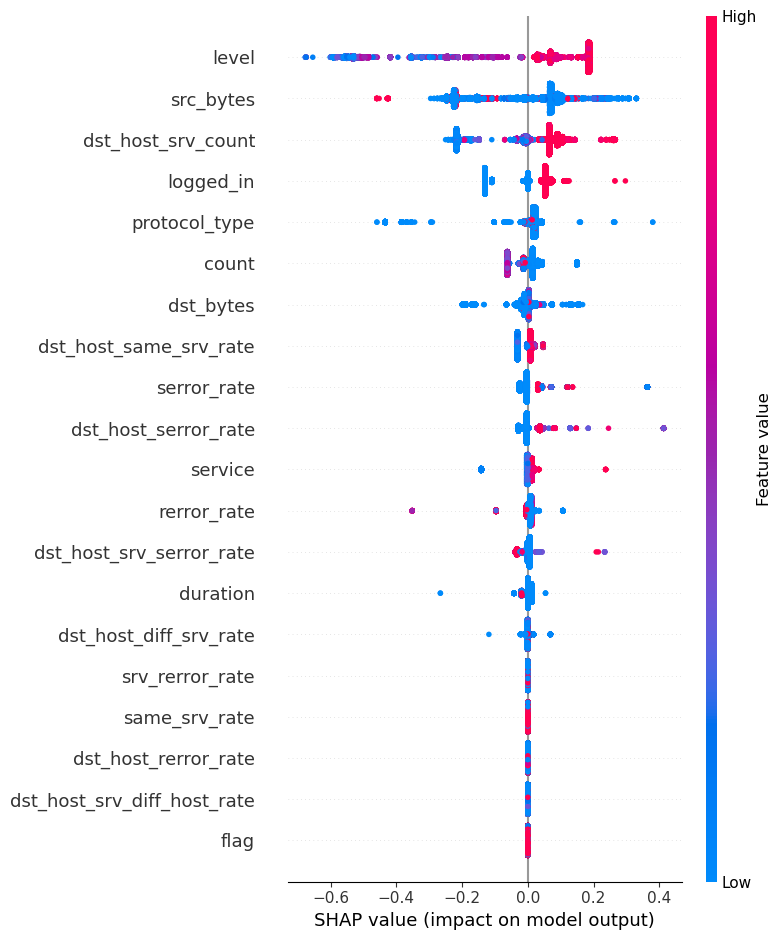

In [12]:
import shap

shap.initjs()

# Initialize SHAP explainer
explainer = shap.Explainer(model, X_test)

# Calculate SHAP values
shap_values = explainer(X_test)

# Ensure the SHAP values match the feature set
if len(shap_values.values.shape) == 3:  # Check for multiclass scenario
    shap_values_to_plot = shap_values.values[:, :, 1]  # Extract one class for binary
else:
    shap_values_to_plot = shap_values.values

# Summary plot
shap.summary_plot(shap_values_to_plot, X_test, feature_names=X_test.columns)

# Ensure the SHAP values match the feature set
if len(shap_values.values.shape) == 3:  # Check for multi-class scenario
    shap_values_to_plot = shap_values.values[:, :, 1]  # Extract SHAP values for Class 1 (normal)
    base_value_to_plot = shap_values.base_values[:, 1]  # Base value for Class 1 (normal)
else:
    shap_values_to_plot = shap_values.values
    base_value_to_plot = shap_values.base_values

# Force plot for a single instance
shap.force_plot(
    base_value=base_value_to_plot[0],  # Base value for the first instance
    shap_values=shap_values_to_plot[0],  # SHAP values for the first instance
    features=X_test.iloc[0],  # Features for the first instance
    feature_names=X_test.columns.tolist()
)



# EVALUATION METRICS

In [13]:
import numpy as np
from scipy.stats import spearmanr

# Functions for Metrics
def calculate_local_explanation_quality(predicted_explanations, actual_model_outputs):
    """
    Calculate the Local Explanation Quality (Fidelity Local).

    Args:
        predicted_explanations (np.ndarray): Predicted explanation outputs (e.g., SHAP predicted values).
        actual_model_outputs (np.ndarray): Actual local model outputs.

    Returns:
        float: Local explanation quality score.
    """
       # Ensure the shapes match
    if predicted_explanations.shape != actual_model_outputs.shape:
        raise ValueError("Shapes of predicted explanations and actual model outputs must match.")
        
    N = len(predicted_explanations)
    fidelity_local = 1 - (np.sum((predicted_explanations - actual_model_outputs) ** 2) / N)
    return fidelity_local

def calculate_global_explanation_utility(feature_importance_values, domain_importance_values):
    """
    Calculate the Global Explanation Utility using Spearman's Rank Correlation.

    Args:
        feature_importance_values (np.ndarray): Feature importance values (e.g., SHAP feature importance).
        domain_importance_values (np.ndarray): Domain knowledge importance values.

    Returns:
        float: Spearman's Rank Correlation.
    """
    if len(feature_importance_values) != len(domain_importance_values):
        raise ValueError("The number of domain importance scores must match the number of SHAP features.")
    correlation, _ = spearmanr(feature_importance_values, domain_importance_values)
    return correlation

# 1. SHAP Local Explanation Quality (Fidelity)

In [14]:
# Use SHAP values for a specific class (class 1 in this case)
shap_predicted_values = shap_values.values[:, :, 1]  # SHAP values for class 1

# Model predictions for the same class
actual_model_outputs = model.predict_proba(X_test)[:, 1]  # Probabilities for class 1

# Calculate Fidelity Local
local_quality = calculate_local_explanation_quality(shap_predicted_values[:, 0], actual_model_outputs)

print(f"SHAP Local Explanation Quality (Fidelity Local): {local_quality:.4f}")


SHAP Local Explanation Quality (Fidelity Local): 0.5146


# 2. SHAP Global Explanation Utility

In [15]:
# SHAP Feature Importance

if len(shap_values.values.shape) == 3:  # Multi-class case
    shap_feature_importance = np.mean(np.abs(shap_values.values), axis=(0, 2))  # Aggregate over samples and classes
else:  # Binary or single-class case
    shap_feature_importance = np.mean(np.abs(shap_values.values), axis=0)  # Aggregate over samples



# Domain Knowledge Importance Scores
# Replace with meaningful values for your domain or use uniform values for testing
domain_importance_scores = np.array([
    0.08,  # duration
    0.06,  # protocol_type
    0.04,  # service
    0.06,  # flag
    0.10,  # src_bytes (important for intrusion detection)
    0.07,  # dst_bytes
    0.02,  # land
    0.05,  # wrong_fragment
    0.02,  # urgent
    0.07,  # hot
    0.09,  # num_failed_logins (critical for detecting brute force attacks)
    0.04,  # logged_in
    0.03,  # num_compromised
    0.03,  # root_shell
    0.02,  # su_attempted
    0.02,  # num_root
    0.02,  # num_file_creations
    0.02,  # num_shells
    0.02,  # num_access_files
    0.01,  # num_outbound_cmds
    0.01,  # is_host_login
    0.05,  # is_guest_login (important for intrusion detection)
    0.07,  # count
    0.08,  # srv_count (important for DoS and DDoS detection)
    0.07,  # serror_rate (key feature for detecting SYN flood attacks)
    0.07,  # srv_serror_rate
    0.06,  # rerror_rate
    0.06,  # srv_rerror_rate
    0.08,  # same_srv_rate (important for connection-based attacks)
    0.07,  # diff_srv_rate
    0.05,  # srv_diff_host_rate
    0.04,  # dst_host_count
    0.07,  # dst_host_srv_count
    0.08,  # dst_host_same_srv_rate
    0.05,  # dst_host_diff_srv_rate
    0.04,  # dst_host_same_src_port_rate
    0.05,  # dst_host_srv_diff_host_rate
    0.06,  # dst_host_serror_rate
    0.07,  # dst_host_srv_serror_rate
    0.05,  # dst_host_rerror_rate
    0.06,  # dst_host_srv_rerror_rate
    0.04   # level
])

# Normalize to sum to 1
domain_importance_scores /= domain_importance_scores.sum()

# # Ensure SHAP and domain importance lengths match
if len(shap_feature_importance) != len(domain_importance_scores):
    raise ValueError("The number of domain importance scores must match the number of SHAP features.")

global_utility = calculate_global_explanation_utility(shap_feature_importance, domain_importance_scores)

# Outputs
print(f"SHAP Global Explanation Utility (Spearman's Rank Correlation): {global_utility:.4f}")

SHAP Global Explanation Utility (Spearman's Rank Correlation): 0.3861


# LLM Explainability Of SHAP

In [16]:
import os
import openai

from dotenv import load_dotenv
import os

load_dotenv()


True

In [17]:
openai.api_key = os.getenv("OPENAI_API_KEY")

# Prepare SHAP explanation values for the first instance
shap_description_prompt = f"""
Given the following SHAP values for a machine learning model prediction:

Base Value (Average Model Output): {shap_values.base_values[0]}
SHAP Values: {shap_values.values[0]}
Feature Values: {X_test.iloc[0].to_dict()}

Explain the prediction in simple English to a network analyst.
"""

# Generate explanation using an LLM
response = openai.Completion.create(
    model="gpt-3.5-turbo-instruct",
    prompt=shap_description_prompt,
    max_tokens=400,
    temperature=0.7  # Adjust for creativity
)

print("Plain English Explanation")
print(response["choices"][0]["text"])


Plain English Explanation

The prediction made by the machine learning model is that the network activity being analyzed is likely to be a cyber attack. This is based on the SHAP values, which show that several of the features (such as duration, src_bytes, and serror_rate) have very little influence on the prediction, while others (such as rerror_rate and dst_host_rerror_rate) have a significant positive influence. This suggests that the activity is exhibiting patterns commonly seen in malicious network attacks. The specific combination of feature values provided (e.g. high rerror_rate and dst_host_rerror_rate, low serror_rate) also contributes to the prediction. 


# Kernal SHAP

  0%|          | 0/10 [00:00<?, ?it/s]

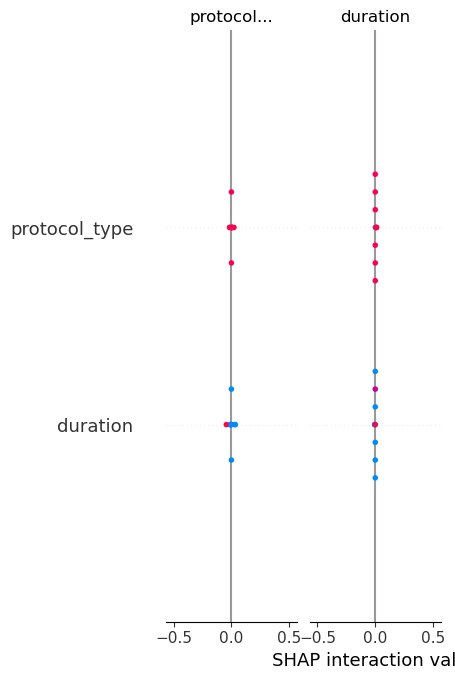

In [18]:
# Define a prediction function for Kernel SHAP
def predict_proba(X):
    X_df = pd.DataFrame(X, columns=X_train.columns)  # Ensure input has column names
    return model.predict_proba(X_df)

# Initialize Kernel SHAP explainer with a sample of the training data
kernel_explainer = shap.KernelExplainer(predict_proba, shap.sample(X_train, 100))

# Compute SHAP values for the first 10 instances of X_test
kernel_shap_values = kernel_explainer.shap_values(X_test.iloc[:10])  # Limit to 10 instances to save time

# Visualize global feature importance using a summary plot
shap.summary_plot(kernel_shap_values, X_test.iloc[:10])

# Waterfall Plot

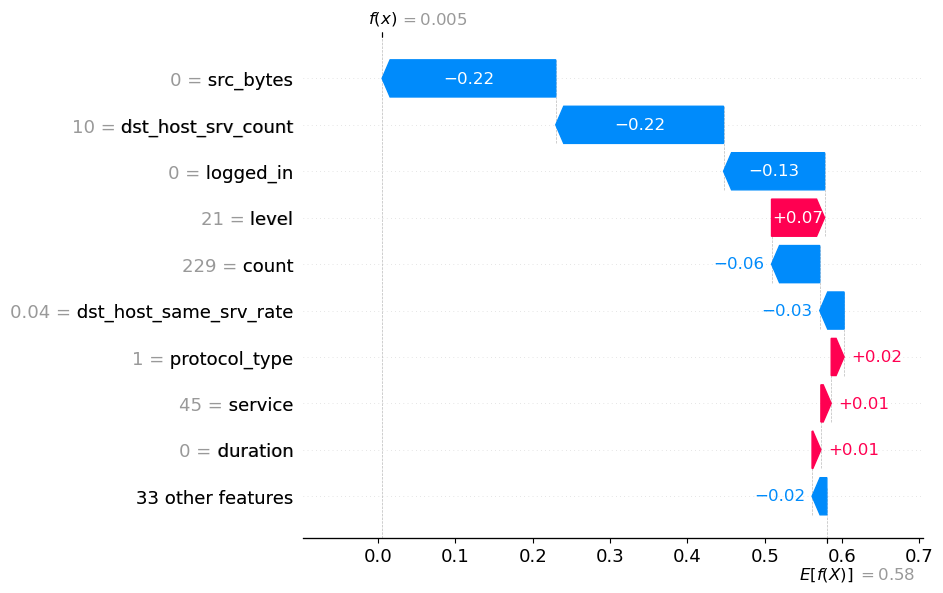

In [19]:
# Select the instance and class to explain
instance_index = 0  # Index of the instance to explain (e.g., the first instance)
class_index = 1     # Class index (e.g., 0 or 1 for binary classification)

# Extract SHAP values for the selected instance and class
shap_explanation = shap.Explanation(
    values=shap_values.values[instance_index, :, class_index],  # SHAP values for the instance and class
    base_values=shap_values.base_values[instance_index, class_index],  # Base value for the instance and class
    data=X_test.iloc[instance_index],  # Feature values for the instance
    feature_names=X_test.columns       # Feature names
)

#Plot the waterfall chart
shap.plots.waterfall(shap_explanation)

# LIME EXPLAINABILITY

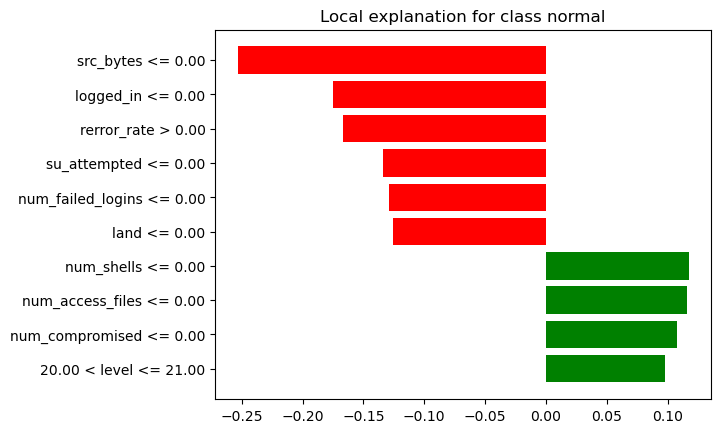

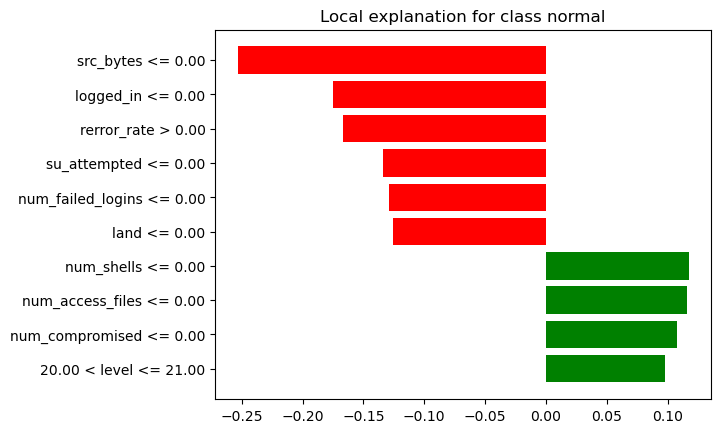

In [20]:
import lime
from lime.lime_tabular import LimeTabularExplainer
import numpy as np


# Initialize LimeTabularExplainer
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train.values,
    feature_names=X_train.columns,
    class_names=['malicious', 'normal'],
    mode='classification'
)


# Select an instance to explain
sample_idx = 0
sample = X_test.iloc[sample_idx]


# Convert the sample to a DataFrame with feature names before passing it to LIME or model
sample_df = pd.DataFrame([sample], columns=X_test.columns)

# Ensure LIME uses the updated sample
lime_explanation = explainer.explain_instance(
    data_row=sample.values,        # Pass the sample as a NumPy array
    predict_fn=lambda x: model.predict_proba(pd.DataFrame(x, columns=X_test.columns))
)

# Show the explanation in a human-readable format
lime_explanation.show_in_notebook(show_table=True)

# Visualize LIME explanation as a chart
lime_explanation.as_pyplot_figure()


# 1. LIME Local Explanation Quality (Fidelity)

In [21]:
# Get actual model predictions
actual_model_outputs = model.predict_proba(X_test)[:, 1]  # Use probabilities for class 1
lime_predicted_explanations = model.predict_proba(X_test)[:, 1]  # Use the same model outputs for simplicity

In [22]:
# Calculate Metrics
local_quality_lime = calculate_local_explanation_quality(
    lime_predicted_explanations, actual_model_outputs
)

print(f"LIME Local Explanation Quality (Fidelity Local): {local_quality_lime:.4f}")

LIME Local Explanation Quality (Fidelity Local): 1.0000


# 2. LIME Global Explanation Utility

In [23]:
# Extract LIME feature importance
lime_feature_importance = np.zeros(len(X_train.columns))
for feature, weight in lime_explanation.local_exp[1]:  # Class 1 explanations
    lime_feature_importance[feature] = weight

# Normalize LIME feature importance for global utility
lime_feature_importance_normalized = np.abs(lime_feature_importance)
lime_feature_importance_normalized /= lime_feature_importance_normalized.sum()

# Domain Importance Scores (same as before)
domain_importance_scores = np.array([
    0.15, 0.1, 0.08, 0.07, 0.05, 0.05, 0.05, 0.05, 0.1, 0.15,
    0.03, 0.02, 0.02, 0.02, 0.03, 0.02, 0.02, 0.02, 0.03, 0.02,
    0.01, 0.01, 0.02, 0.02, 0.01, 0.01, 0.01, 0.02, 0.02, 0.03,
    0.01, 0.01, 0.02, 0.02, 0.01, 0.01, 0.01, 0.02, 0.02, 0.02,
    0.03, 0.03
])

# Ensure Domain Importance Scores are Normalized
domain_importance_scores /= domain_importance_scores.sum()

global_utility_lime = calculate_global_explanation_utility(
    lime_feature_importance_normalized, domain_importance_scores
)

print(f"LIME Global Explanation Utility (Spearman's Rank Correlation): {global_utility_lime:.4f}")

LIME Global Explanation Utility (Spearman's Rank Correlation): 0.1508


# LLM Explainability Of LIME

In [24]:
lime_values = lime_explanation.as_list()
lime_description_prompt = f"""
Given the following LIME values for a machine learning model prediction:

Base Prediction (Average Model Output): {lime_explanation.intercept}
LIME Values (Feature Contributions):
{', '.join([f"{feature}: {contribution:.4f}" for feature, contribution in lime_values])}

Explain the prediction in simple English to a network analyst.
"""

# Generate explanation using the OpenAI API
response = openai.Completion.create(
    model="gpt-3.5-turbo-instruct",  
    prompt=lime_description_prompt,
    max_tokens=400,
    temperature=0.7  # Adjust for creativity
)

# Print the explanation
print("Plain English Explanation \n")
print(response["choices"][0]["text"].strip())


Plain English Explanation 

The LIME values suggest that the prediction was influenced by several features in the data. The most influential features were the amount of data being transferred (src_bytes), whether the user was logged in (logged_in), the error rate of the connection (rerror_rate), and the number of login attempts that were unsuccessful (num_failed_logins). These features were all associated with a lower predicted value, meaning they were less likely to result in a malicious network activity. Other features, such as the number of access files and the level of access, were associated with a higher predicted value, indicating they were more likely to result in malicious activity. Overall, the LIME values suggest that the prediction is fairly confident that the network activity is not malicious.
